In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [73]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import pandas as pd
import os
from scipy.signal import argrelextrema
from scipy.signal import gaussian
from scipy.stats import pearsonr
from scipy.stats import binom_test
import seaborn as sns
import itertools as it
import fnmatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def findClosestPoint(values,array):
    values = np.array(values)
    array = np.array(array)
    idx = np.array([np.square(array - value).argmin() for value in values])
    return idx,array[idx]

In [75]:
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/'
dbList = sorted([os.path.join(item[0],item[1]) for item in locate('awakeReplays-*.db',dataFolder)])

In [88]:
animal_ids = [614,616,3661,3906]
###############DataFrame
dfAll = pd.DataFrame([],columns=['ti','tf','tp','tSub','lSub','rSub','Lcorr','Rcorr','Lpv','Rpv','animal_ID'])
for db in dbList:
    dff = pd.read_pickle(db)
    dff = dff[(dff.lSub>3)^(dff.rSub>3)]
    dfAll = dfAll.append(dff,ignore_index=True)
#############################################
binwidth = 0.1
A = np.linspace(0,1.,1.0/binwidth+1)
binwidth = np.diff(A)[0]
corrBinsCenters = np.union1d(-1*A,A)
corrBins = corrBinsCenters-binwidth/2
corrBins = np.insert(corrBins,[corrBins.size],[corrBins[-1]+binwidth])
##########################################
surrProbs = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBins,normed=True)[0]
    surrProbs.append(hst)
#################################
for anID in animal_ids:
    print anID
    df = dfAll[dfAll.animal_ID==anID]
    for n in range(4,11):
        print n,
        print '--->',
        dfLsub = df[df.lSub==n]
        dfRsub = df[df.rSub==n]
        hstL = np.histogram(dfLsub.Lcorr,corrBins)[0]
        hstR = np.histogram(dfRsub.Rcorr,corrBins)[0]
        for item in np.where(hstL)[0]:
            p_value = binom_test(hstL[item],hstL.sum(),surrProbs[n-4][item]*binwidth)
            if p_value < 0.05:
                idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
                locs = dfLsub.index[idxs]
                dfAll.Lpv[locs] += (p_value-1)
        for item in np.where(hstR)[0]:
            p_value = binom_test(hstR[item],hstR.sum(),surrProbs[n-4][item]*binwidth)
            if p_value < 0.05:
                idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
                locs = dfRsub.index[idxs]
                dfAll.Rpv[locs] += (p_value-1)
            #print p_value

    #print '##############################################################################'
    ###################################################################################
    print '10++'
    dfLsub = df[df.lSub>10]
    dfRsub = df[df.rSub>10]
    hstL = np.histogram(dfLsub.Lcorr,corrBins)[0]
    hstR = np.histogram(dfRsub.Rcorr,corrBins)[0]
    for item in np.where(hstL)[0]:
        #print hstL[item],corrBinsCenters[item]
        p_value = binom_test(hstL[item],hstL.sum(),surrProbs[-1][item]*binwidth)
        if p_value < 0.05:
            #print corrBinsCenters[item],p_value
            idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
            locs = dfLsub.index[idxs]
            dfAll.Lpv[locs] += (p_value-1)
    print '####################'
    for item in np.where(hstR)[0]:
        #print hstR[item],corrBinsCenters[item]
        p_value = binom_test(hstR[item],hstR.sum(),surrProbs[-1][item]*binwidth)
        if p_value < 0.05:
            idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
            locs = dfRsub.index[idxs]
            dfAll.Rpv[locs] += (p_value-1)

614
4 ---> 5 ---> 6 ---> 7 ---> 8 ---> 9 ---> 10 ---> 10++
####################
616
4 ---> 5 ---> 6 ---> 7 ---> 8 ---> 9 ---> 10 ---> 10++
####################
3661
4 ---> 5 ---> 6 ---> 7 ---> 8 ---> 9 ---> 10 ---> 10++
####################
3906
4 ---> 5 ---> 6 ---> 7 ---> 8 ---> 9 ---> 10 ---> 10++
####################


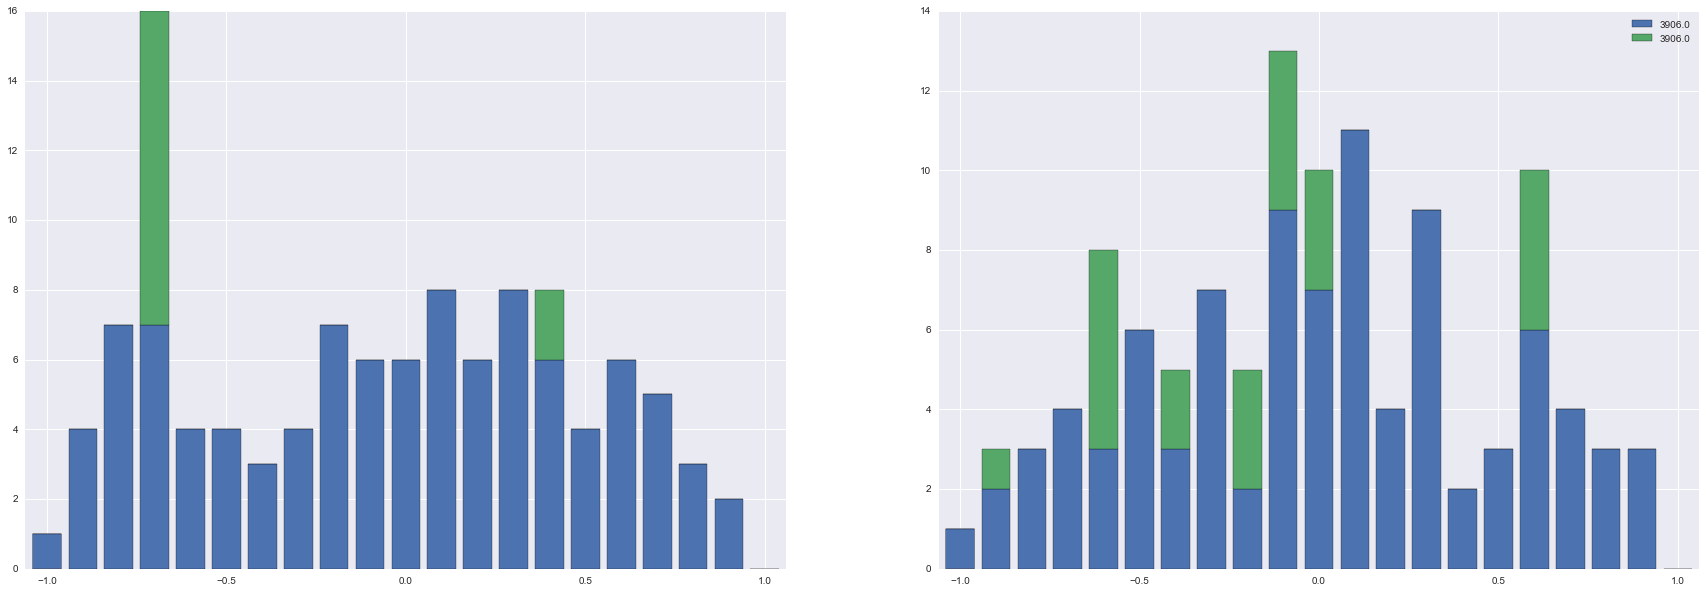

In [91]:
fig,(ax,bx) = pl.subplots(1,2,figsize=[30,10],sharex=True)
ax.hist([dfAll[(dfAll.Lpv==1)&(dfAll.lSub>4)].Lcorr,dfAll[(dfAll.Lpv!=1)&(dfAll.lSub>4)].Lcorr],corrBins,label=[],normed=False,stacked=True);
bx.hist([dfAll[(dfAll.Rpv==1)&(dfAll.rSub>4)].Rcorr,dfAll[(dfAll.Rpv!=1)&(dfAll.rSub>4)].Rcorr],corrBins,label=[],normed=False,stacked=True);
ax.set_xlim(-1.06,1.06)
pl.legend([str(np.unique(df.animal_ID)[0]),str(np.unique(df.animal_ID)[0])])

In [92]:
corrMax = []
sigz = np.zeros(dfAll.shape[0])
Lsigz = dfAll.Lpv<5e-2
Rsigz = dfAll.Rpv<5e-2
Lnan = np.isnan(dfAll.Lcorr)
Rnan = np.isnan(dfAll.Rcorr)
ValidIdx = dfAll.index[np.logical_not(np.logical_and(Lnan,Rnan))]
#####################################################################
for idx in dfAll.index:
    if Lsigz[idx] and Rsigz[idx]:
        sigz[idx]+=1
        LRc = np.argmax([np.abs(dfAll.Rcorr[idx]),np.abs(dfAll.Lcorr[idx])])
        if LRc:
            corrMax.append(dfAll.Lcorr[idx])
        else:
            corrMax.append(dfAll.Rcorr[idx])
    elif Lsigz[idx]:
        sigz[idx]+=1
        corrMax.append(dfAll.Lcorr[idx])
    elif Rsigz[idx]:
        sigz[idx]+=1
        corrMax.append(dfAll.Rcorr[idx])
    elif np.isnan(dfAll.Lcorr[idx]):
        corrMax.append(dfAll.Rcorr[idx])
    elif np.isnan(dfAll.Rcorr[idx]):
        corrMax.append(dfAll.Lcorr[idx])
    else:
        LRc = np.argmax([np.abs(dfAll.Rcorr[idx]),np.abs(dfAll.Lcorr[idx])])
        if LRc:
            corrMax.append(dfAll.Lcorr[idx])
        else:
            corrMax.append(dfAll.Rcorr[idx])

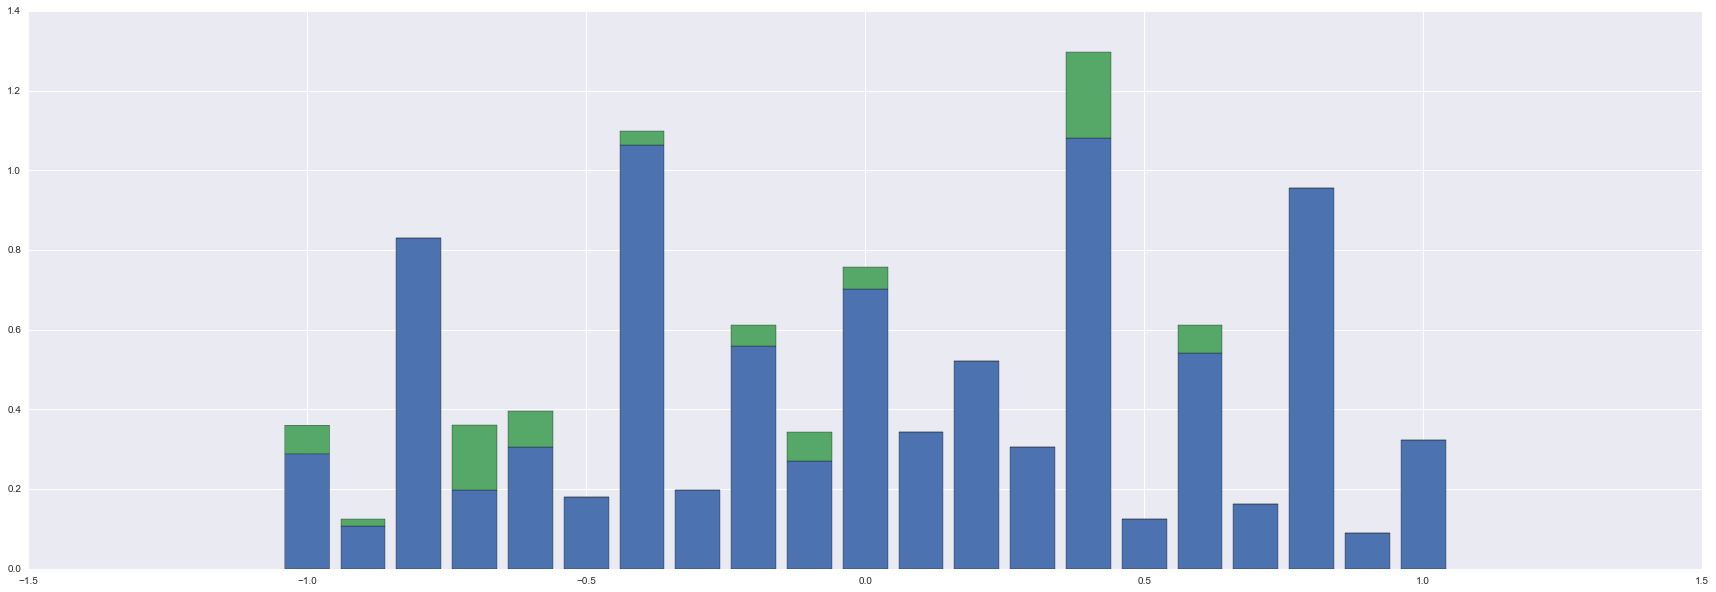

In [93]:
fig,ax = pl.subplots(1,1,figsize=[30,10],sharex=True)
corrMax = np.array(corrMax)
pl.hist([corrMax[np.where(sigz==0)[0]],corrMax[np.where(sigz)[0]]],corrBins,stacked=True,normed=True);

In [114]:
roDB = pd.DataFrame([],columns=['ti','tf','tp','tSub','lSub','rSub','Lcorr','Rcorr','Lpv','Rpv','animal_ID'])
for db in dbList:
    dff = pd.read_pickle(db)
    dff = dff[(dff.lSub>4)^(dff.rSub>4)]
    roDB = roDB.append(dff,ignore_index=True)
###########################################################
idx = [findClosestPoint([0.025],binwidth*np.cumsum(surrProbs[n-5]))[0] for n in range(5,11)]
SigCorrMin = [np.abs(corrBinsCenters[ii+1][0]) for ii in idx]
for idx,row in roDB.iterrows():
    if row.lSub>1:
        if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 5),len(SigCorrMin)-1)]:
            row.Lpv-=0.96
    if row.rSub>1:
        if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 5),len(SigCorrMin)-1)]:
            row.Rpv-=0.96
    

(-1.06, 1.06)

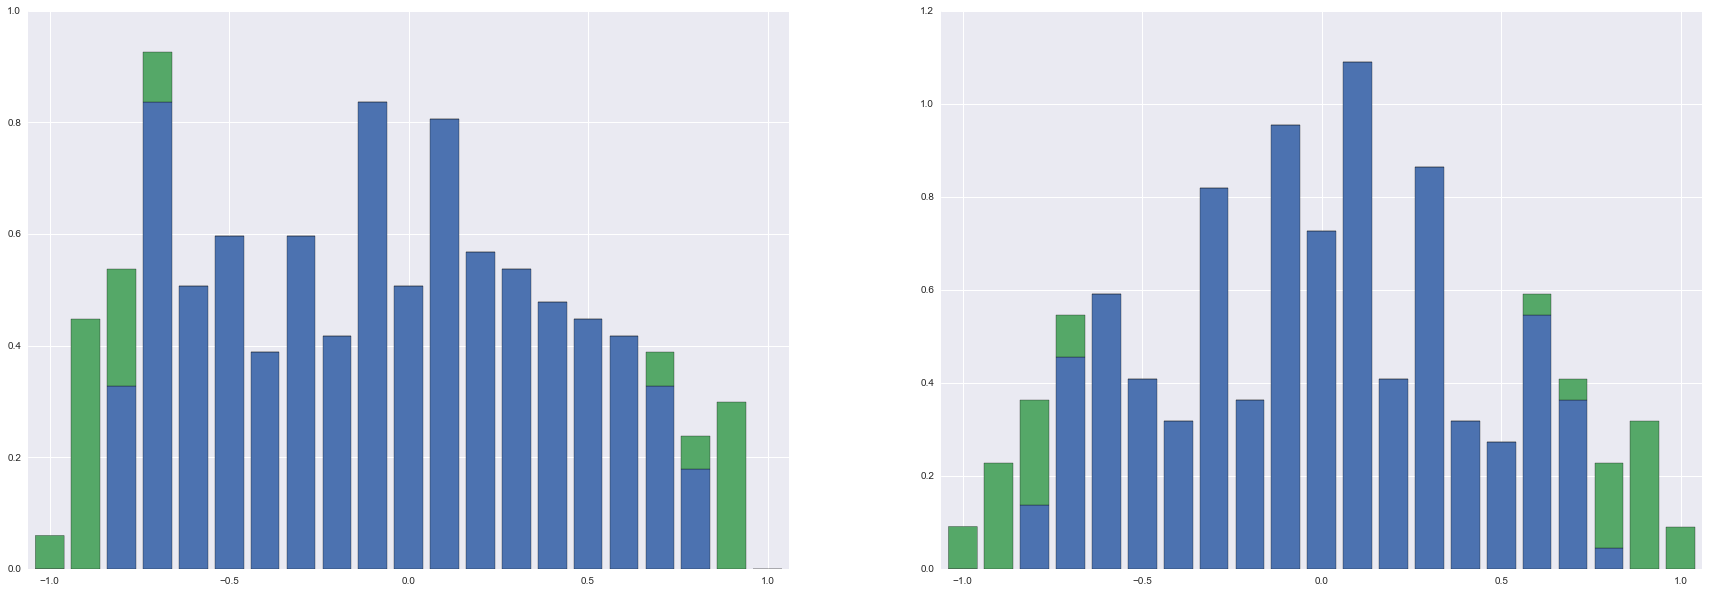

In [105]:
fig,(ax,bx) = pl.subplots(1,2,figsize=[30,10],sharex=True)
LEFT = ax.hist([roDB[(roDB.Lpv==1)&(roDB.lSub>4)].Lcorr,roDB[(roDB.Lpv!=1)&(roDB.lSub>4)].Lcorr],corrBins,label=[],normed=True,stacked=True);
bx.hist([roDB[(roDB.Rpv==1)&(roDB.rSub>4)].Rcorr,roDB[(roDB.Rpv!=1)&(roDB.rSub>4)].Rcorr],corrBins,label=[],normed=True,stacked=True);
ax.set_xlim(-1.06,1.06)
#pl.legend([str(dff.animal_ID[0]),str(dff.animal_ID[0])])

In [135]:
roDB = pd.DataFrame([],columns=['ti','tf','tp','tSub','lSub','rSub','Lcorr','Rcorr','Lpv','Rpv','animal_ID'])
for db in dbList:
    dff = pd.read_pickle(db)
    dff = dff[(dff.lSub>4)^(dff.rSub>4)]
    roDB = roDB.append(dff,ignore_index=True)
####################################################
for anID in animal_ids:
    print '*******************************************'
    print anID
    df = roDB[roDB.animal_ID==anID]
    for idx,row in df.iterrows():
        if row.lSub>1:
            if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 5),len(SigCorrMin)-1)]:
                row.Lpv-=0.96
        if row.rSub>1:
            if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 5),len(SigCorrMin)-1)]:
                row.Rpv-=0.96
    for n in range(5,20):
        dbN = df[df.lSub==n]
        if dbN[dbN.Lpv<0.5].shape[0]:
            print n,dbN.shape[0],dbN[dbN.Lpv<0.5].shape[0]
            print binom_test(dbN[dbN.Lpv<0.5].shape[0],dbN.shape[0],5e-2)
    print '------------------------'
    print '########################'
    for n in range(5,20):
        dbN = df[df.rSub==n]
        if dbN[dbN.Rpv<0.5].shape[0]:
            print n,dbN.shape[0],dbN[dbN.Rpv<0.5].shape[0]
            print binom_test(dbN[dbN.Rpv<0.5].shape[0],dbN.shape[0],5e-2)
    print '------------------------'

*******************************************
614
6 23 3
0.105174326928
7 11 1
0.431199907724
------------------------
########################
6 17 4
0.00880060494769
------------------------
*******************************************
616
6 10 2
0.0861383558993
------------------------
########################
6 7 4
0.000193578125
------------------------
*******************************************
3661
5 114 2
0.13161548678
6 38 5
0.0397266342067
------------------------
########################
5 37 2
0.708108452642
6 11 1
0.431199907724
9 1 1
0.05
------------------------
*******************************************
3906
6 16 3
0.0429378534858
7 12 1
0.459639912337
9 3 1
0.142625
------------------------
########################
5 33 2
0.680376050643
6 23 1
1.0
------------------------


In [127]:
roDB.rSub.max()

11.0